In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
kernel_size = 35
D = 128
E = 128 * 16
L = 1024
B = 2

In [3]:
###### PARAMS ######
logit_alpha = torch.randn(E)  # [E]
logit_delta = torch.randn(E)  # [E]
beta = torch.randn(D, E)      # [D, E]
eta = torch.randn(E, D)       # [E, D]

###### INPUT ######
x = torch.randn(B, L, D)            # [B, L, D]

In [4]:
alpha = F.sigmoid(logit_alpha.view(-1, 1, 1))      # [E, 1, 1]
delta = F.sigmoid(logit_delta.view(-1, 1, 1))      # [E, 1, 1]

p = alpha  # [E, 1, 1]
q = 1. - alpha * delta  # [E, 1, 1]

len_range = (
    torch
    .arange(
        kernel_size-1, -1, -1,
        dtype=logit_alpha.dtype,
        device=logit_alpha.device
    )
    .view(1, 1, -1)
)

kernel = (p * torch.exp(torch.log(q) * len_range))  # [E, 1, kernel_size]

In [5]:
kernel

tensor([[[7.4075e-04, 8.9462e-04, 1.0805e-03,  ..., 3.1094e-01,
          3.7553e-01, 4.5353e-01]],

        [[7.4659e-15, 1.9191e-14, 4.9331e-14,  ..., 9.8551e-02,
          2.5333e-01, 6.5117e-01]],

        [[1.0649e-06, 1.5591e-06, 2.2825e-06,  ..., 2.1133e-01,
          3.0939e-01, 4.5296e-01]],

        ...,

        [[1.2570e-09, 2.2824e-09, 4.1442e-09,  ..., 2.4491e-01,
          4.4469e-01, 8.0744e-01]],

        [[1.8443e-06, 2.6680e-06, 3.8594e-06,  ..., 2.4931e-01,
          3.6064e-01, 5.2169e-01]],

        [[1.0381e-02, 1.1475e-02, 1.2685e-02,  ..., 2.5646e-01,
          2.8349e-01, 3.1337e-01]]])

In [6]:
u = x @ beta  # [B, L, E]
u_T = u.transpose(-1, -2)  # [B, E, L]
out_T = F.conv1d(u_T, kernel, padding=kernel_size - 1, groups=E)  # [B, E, L+kernel_size-1]
out = out_T[..., :L].transpose(-1, -2)  # [B, L, E]
out_proj = out @ eta  # [B, L, D]

In [7]:
out_proj.shape

torch.Size([2, 1024, 128])

In [8]:
kernel.shape

torch.Size([2048, 1, 35])

## FFT

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [25]:
B = 2
L = 7
D = 4
E = 8
kernel_size = 8

inp = torch.ones(B, E, L)            # [B, E, L]
kernel = (0.5 ** torch.arange(kernel_size)).repeat((E, 1))  # [E, kernel_size]
kernel = kernel.flip(dims=(-1,))

In [26]:
def get_rfft():
    fft_dim = L + kernel_size
    # get next power of 2
    # fft_dim = 2 ** (fft_dim - 1).bit_length()

    inp_fft = torch.fft.rfft(inp, dim=-1, n=fft_dim)
    kernel_fft = torch.fft.rfft(kernel, dim=-1, n=fft_dim)

    # Perform element-wise multiplication in the frequency domain
    out_T_fft = inp_fft * kernel_fft
    out_T = torch.fft.irfft(out_T_fft, n=fft_dim).type_as(inp)
    # pad1 = kernel_size // 2
    # pad2 = fft_dim - L - pad1
    return out_T

def get_conv():
    out_T = F.conv1d(inp, kernel.view(E, 1, kernel_size).flip(dims=(2,)), groups=E, padding=kernel_size-1)
    return out_T

In [27]:
get_rfft()[0, 1, :]

tensor([7.8124e-03, 2.3437e-02, 5.4687e-02, 1.1719e-01, 2.4219e-01, 4.9219e-01,
        9.9219e-01, 1.9844e+00, 1.9688e+00, 1.9375e+00, 1.8750e+00, 1.7500e+00,
        1.5000e+00, 1.0000e+00, 2.3842e-08])

In [28]:
get_conv()[0, 1, :]

tensor([0.0078, 0.0234, 0.0547, 0.1172, 0.2422, 0.4922, 0.9922, 1.9844, 1.9688,
        1.9375, 1.8750, 1.7500, 1.5000, 1.0000])

## Debugging trained models

In [13]:
# load torch dict from pytorch_model.bin
import torch
import numpy as np
import os
import seaborn as sns

torch_dict = torch.load('../out/listops/ema/lightning_logs/version_23/checkpoints/epoch=0-val_accuracy=0.17.ckpt')

In [14]:
state_dict = torch_dict["state_dict"]

In [15]:
state_dict.keys()

odict_keys(['model.embedding.weight', 'model.model.layers.0.layer.logit_alpha', 'model.model.layers.0.layer.logit_delta', 'model.model.layers.0.layer.beta', 'model.model.layers.0.layer.eta', 'model.model.layers.1.sublayers.0.layer.weight', 'model.model.layers.1.sublayers.0.layer.bias', 'model.model.layers.1.sublayers.2.layer.weight', 'model.model.layers.1.sublayers.2.layer.bias', 'model.model.layers.1.sublayers.3.layer.weight', 'model.model.layers.1.sublayers.3.layer.bias', 'model.model.layers.2.layer.logit_alpha', 'model.model.layers.2.layer.logit_delta', 'model.model.layers.2.layer.beta', 'model.model.layers.2.layer.eta', 'model.model.layers.3.sublayers.0.layer.weight', 'model.model.layers.3.sublayers.0.layer.bias', 'model.model.layers.3.sublayers.2.layer.weight', 'model.model.layers.3.sublayers.2.layer.bias', 'model.model.layers.3.sublayers.3.layer.weight', 'model.model.layers.3.sublayers.3.layer.bias', 'model_with_head.model.embedding.weight', 'model_with_head.model.model.layers.0.

/tmp/ipykernel_633788/2175118309.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(torch.sigmoid(state_dict["model.model.layers.2.layer.logit_alpha"]).cpu().numpy())


<Axes: ylabel='Density'>

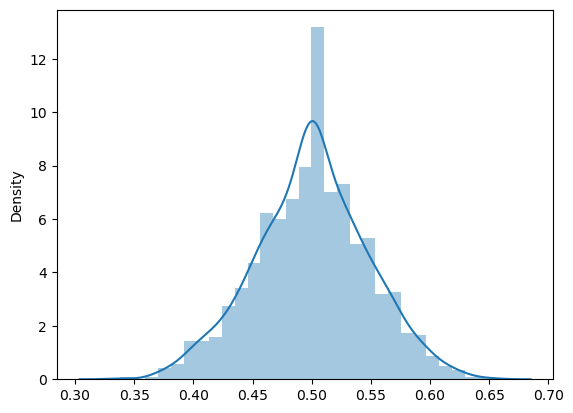

In [24]:
# plot alpha
sns.distplot(torch.sigmoid(state_dict["model.model.layers.2.layer.logit_alpha"]).cpu().numpy())